# Recurrent Neural Networks

## Time series predicting using RNN

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib

import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

T = 20
L = 1000
N = 100

## Generating the data

In [2]:
x = np.empty((N, L), 'int32')

x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)



data = np.array(x/1000.).astype('float32') 

# load data and make training set
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
print (input)


test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])


tensor([[ 0.0570,  0.0580,  0.0590,  ...,  1.0530,  1.0540,  1.0550],
        [ 0.0530,  0.0540,  0.0550,  ...,  1.0490,  1.0500,  1.0510],
        [-0.0010,  0.0000,  0.0010,  ...,  0.9950,  0.9960,  0.9970],
        ...,
        [-0.0440, -0.0430, -0.0420,  ...,  0.9520,  0.9530,  0.9540],
        [ 0.0230,  0.0240,  0.0250,  ...,  1.0190,  1.0200,  1.0210],
        [-0.0730, -0.0720, -0.0710,  ...,  0.9230,  0.9240,  0.9250]])


## Building the Neural network
When we deal with Time Serie we need prevent problems such as vanishing gradient. Therefore we use particular architecture. The LSTM is the most common but recently a new one has became the state of the art architecture ensuring good result and better performances.
![image](https://user-images.githubusercontent.com/45148200/50423198-b051c480-0852-11e9-8940-1f8fd5c08542.png)



In [3]:
class Sequence(nn.Module):
    def __init__(self, hdim):
        super(Sequence, self).__init__()
        self.rnn = nn.GRUCell(1, hdim)
        self.linear = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, input, future = 0):
        outputs = []
        
        # create a tensor for the hidden state initialized to zero
        h_t = torch.zeros((input.size(0),self.hdim))

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            # apply the RNN
            h_t = self.rnn(input_t,h_t)
            # apply the linear layer 
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):# if we should predict the future
            
            # apply the RNN to the last value
            h_t =  self.rnn(output,h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

## RNN component

Since we can load the whole data to train we use LBFGS as optimizer 

In [4]:
# build the model with 10 hidden units
seq = Sequence(10)
print(seq(input))
criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

tensor([[-0.0763, -0.0613, -0.0631,  ..., -0.1100, -0.1100, -0.1101],
        [-0.0761, -0.0611, -0.0630,  ..., -0.1099, -0.1099, -0.1099],
        [-0.0744, -0.0591, -0.0610,  ..., -0.1081, -0.1081, -0.1081],
        ...,
        [-0.0730, -0.0575, -0.0595,  ..., -0.1067, -0.1067, -0.1067],
        [-0.0752, -0.0600, -0.0619,  ..., -0.1089, -0.1089, -0.1089],
        [-0.0721, -0.0565, -0.0584,  ..., -0.1057, -0.1057, -0.1058]],
       grad_fn=<SqueezeBackward1>)


## Training & predicting the "future"

STEP: 0 loss: 5.794293247163296e-055 test loss: 4.777855065185577e-05


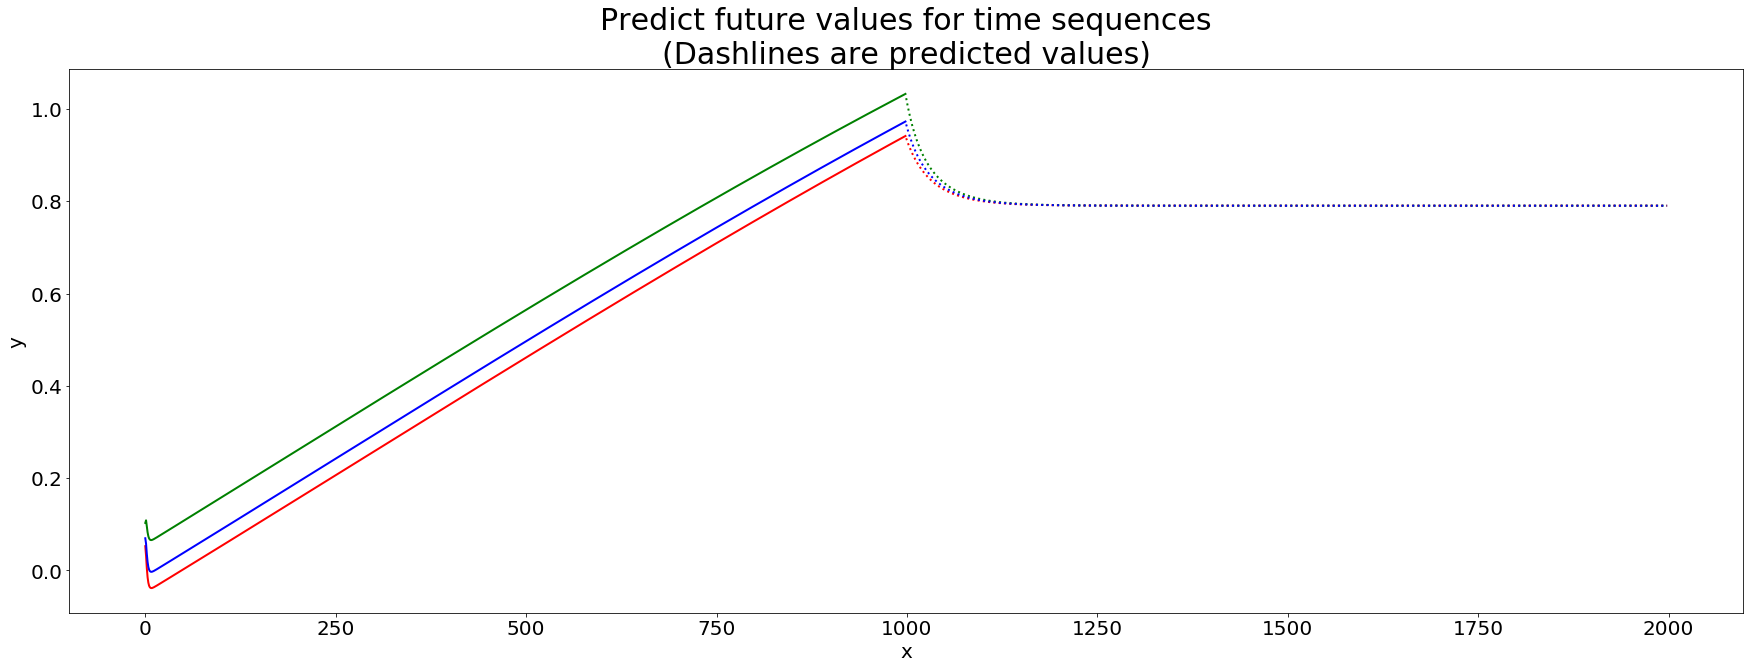

STEP: 1 loss: 4.2007395677501336e-06 test loss: 4.058900231029838e-06


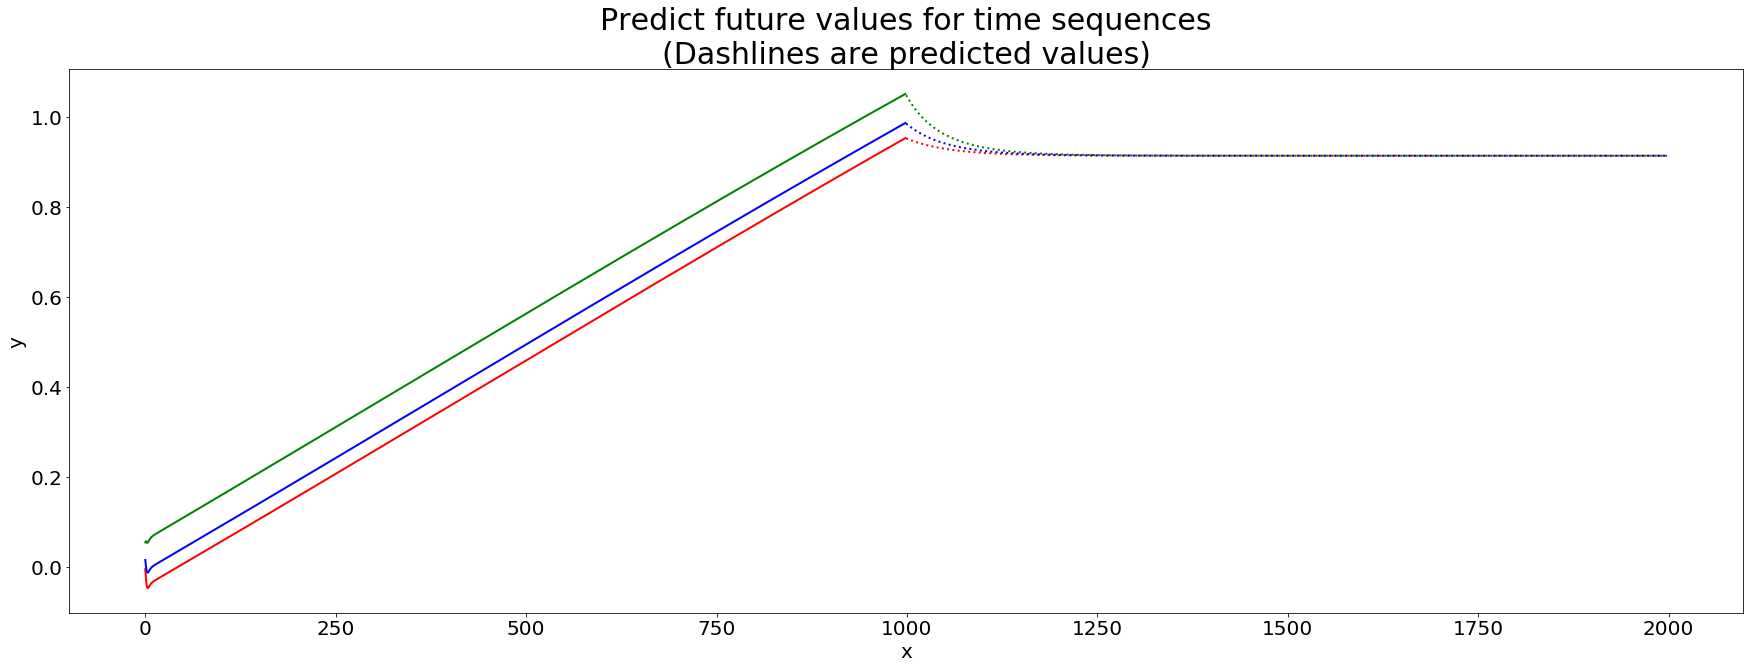

STEP: 2 loss: 1.926467803059495e-066 test loss: 1.7227514490514295e-06


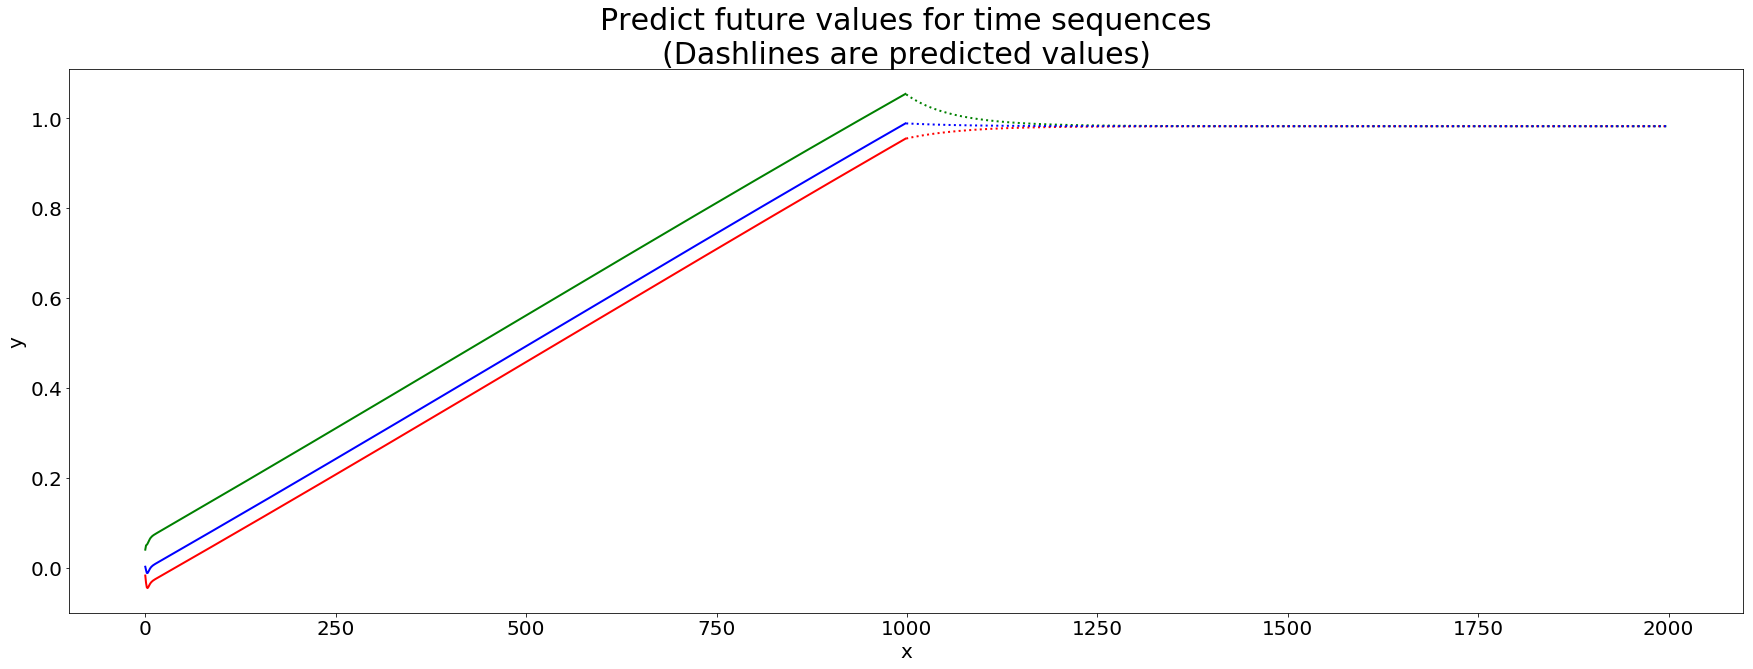

STEP: 3 loss: 1.926290224218974e-06 test loss: 1.7219859955730499e-06


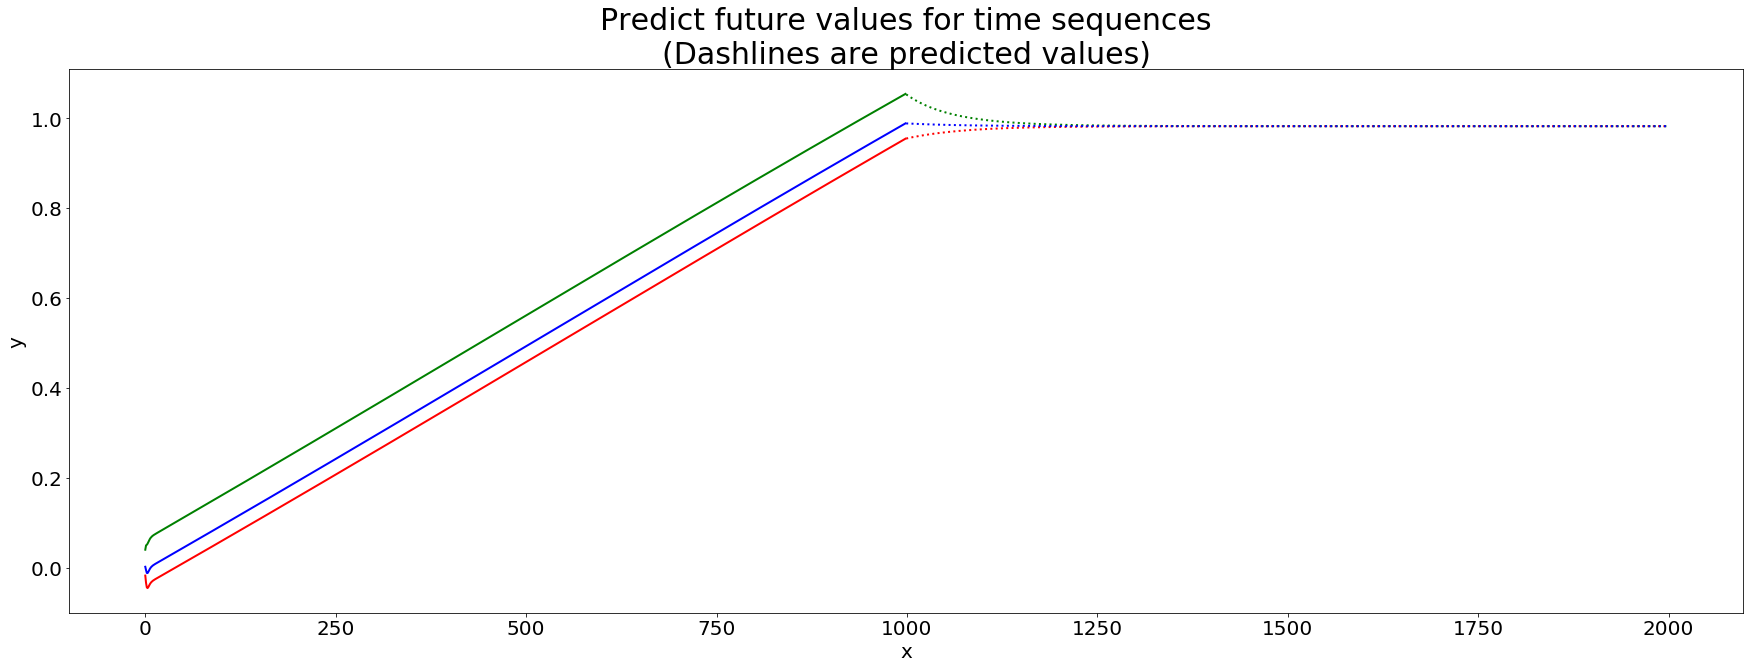

STEP: 4 loss: 1.9261924535385333e-06 test loss: 1.721499529594439e-06


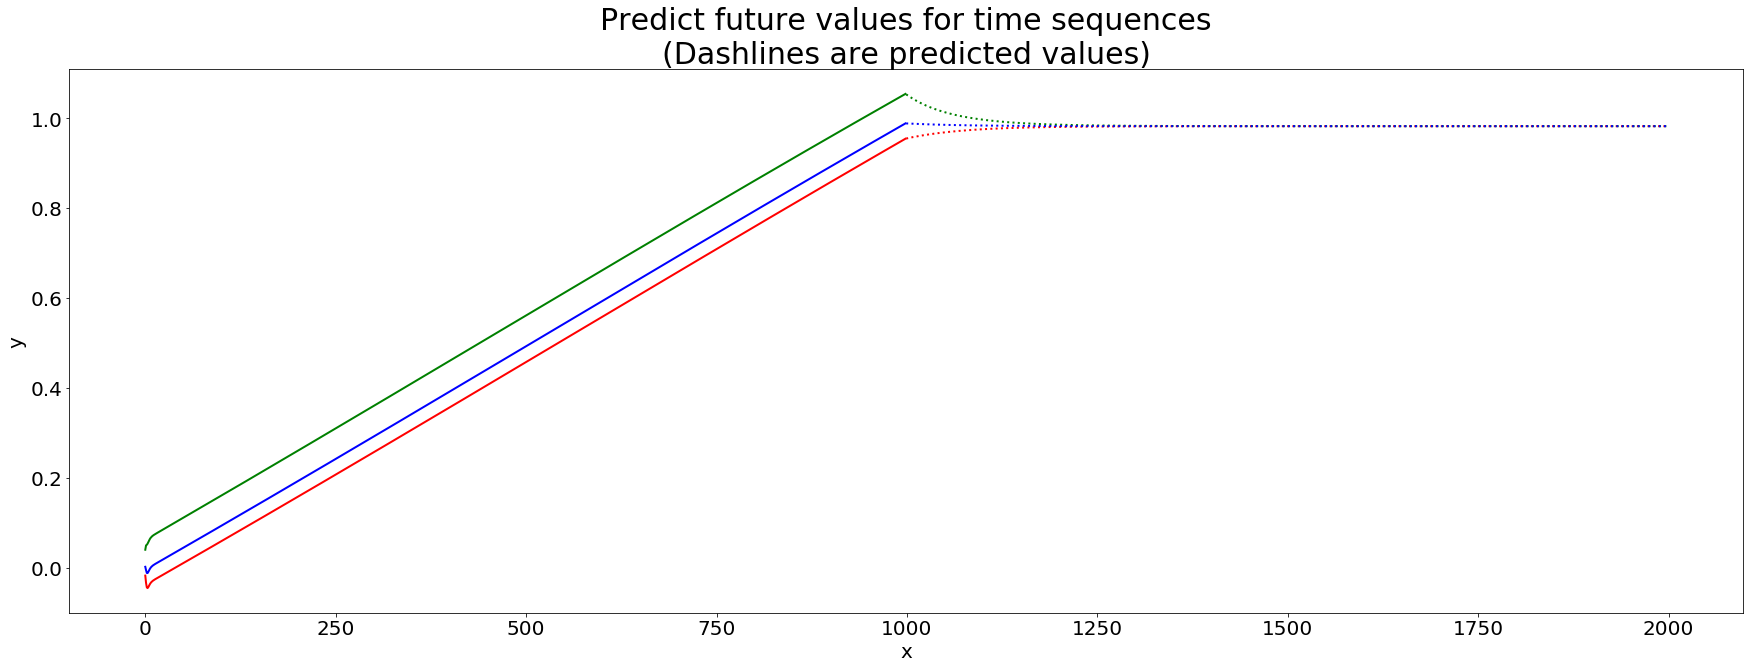

STEP: 5 loss: 1.9261146917415317e-06 test loss: 1.7213176306540845e-06


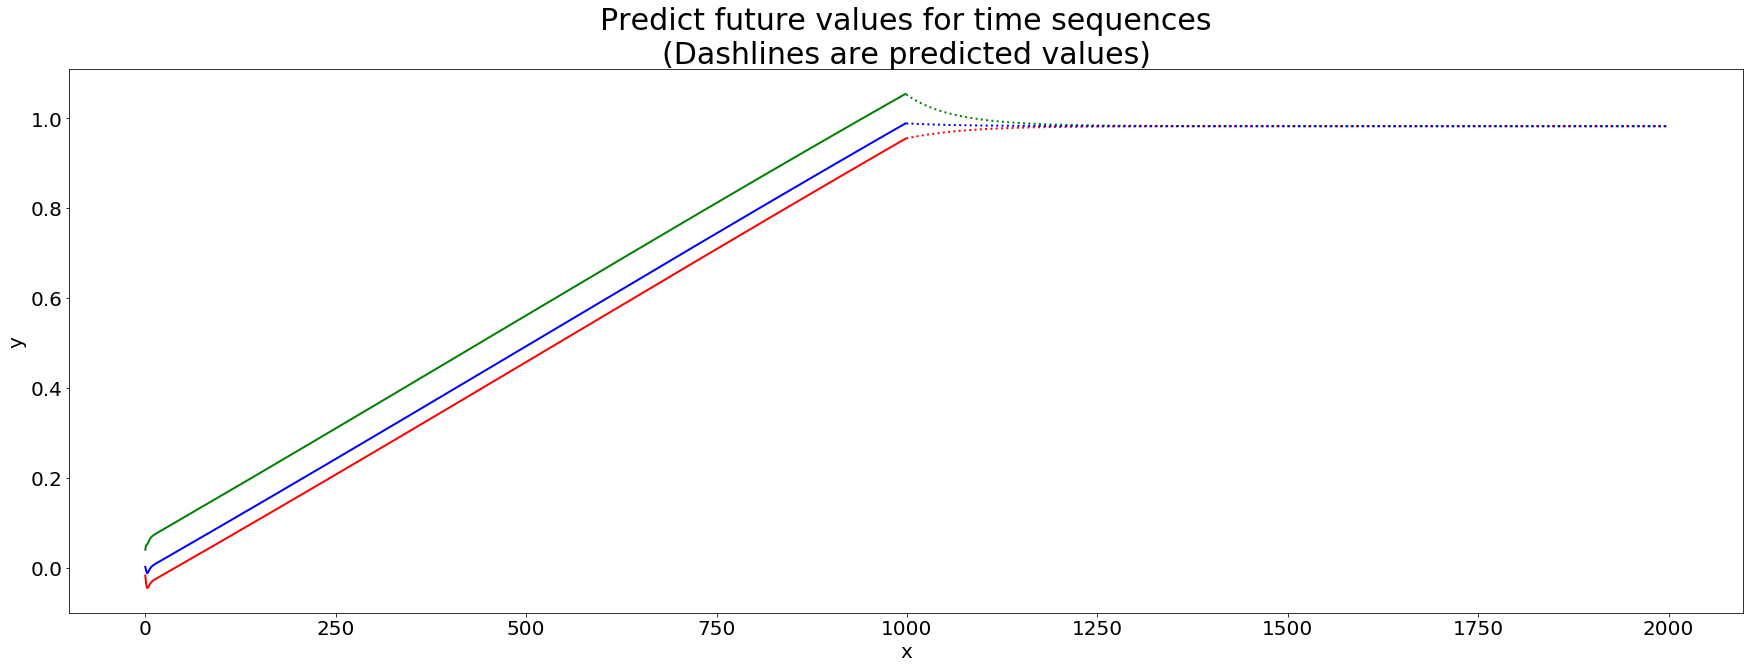

STEP: 6 loss: 1.926021013787249e-066 test loss: 1.7212074681083323e-06


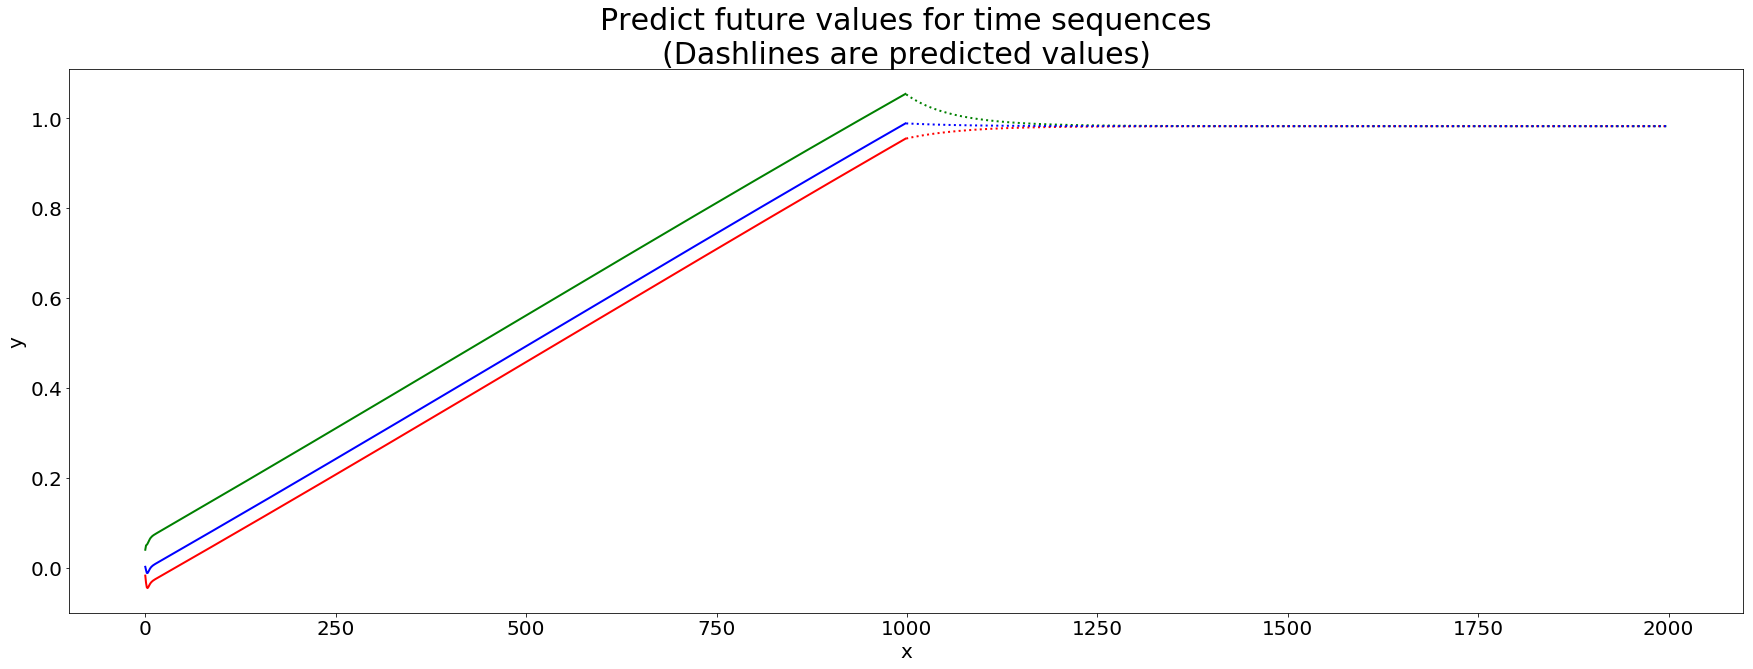

STEP: 7 loss: 1.9259637156210374e-06 test loss: 1.721147555144853e-06


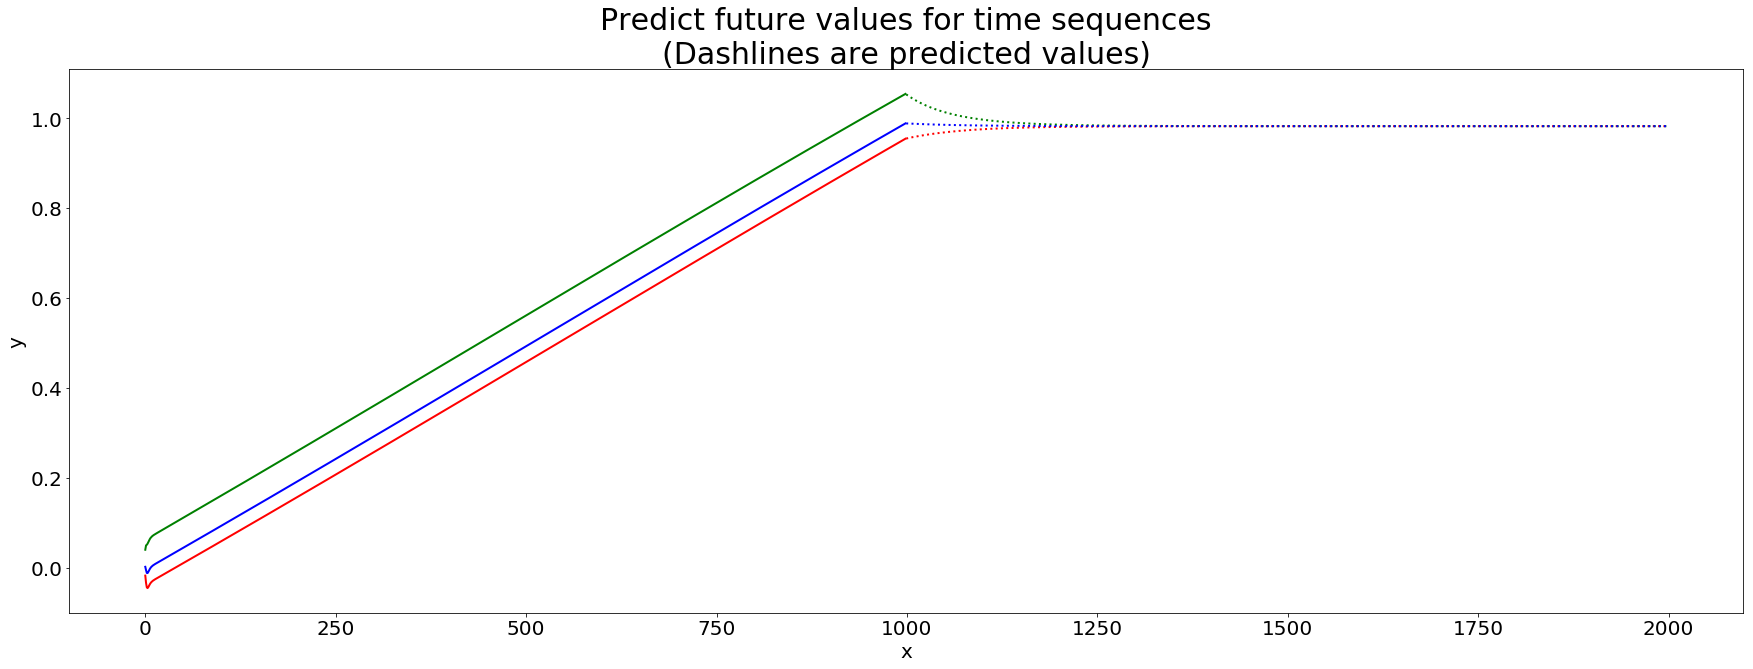

STEP: 8 loss: 1.9258570773672545e-06 test loss: 1.7210497844644124e-06


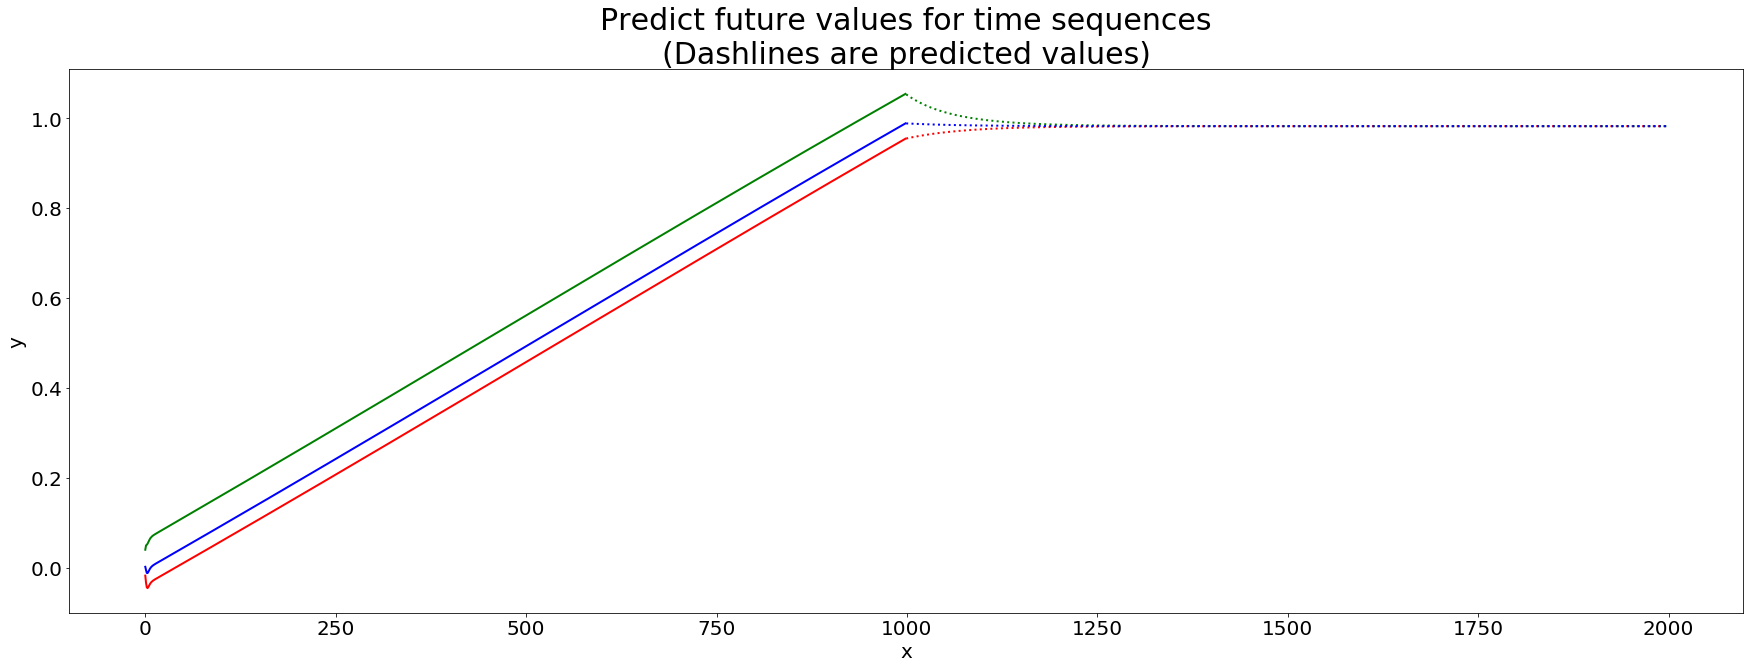

STEP: 9 loss: 1.92579841495899e-0606 test loss: 1.7209927136718761e-06


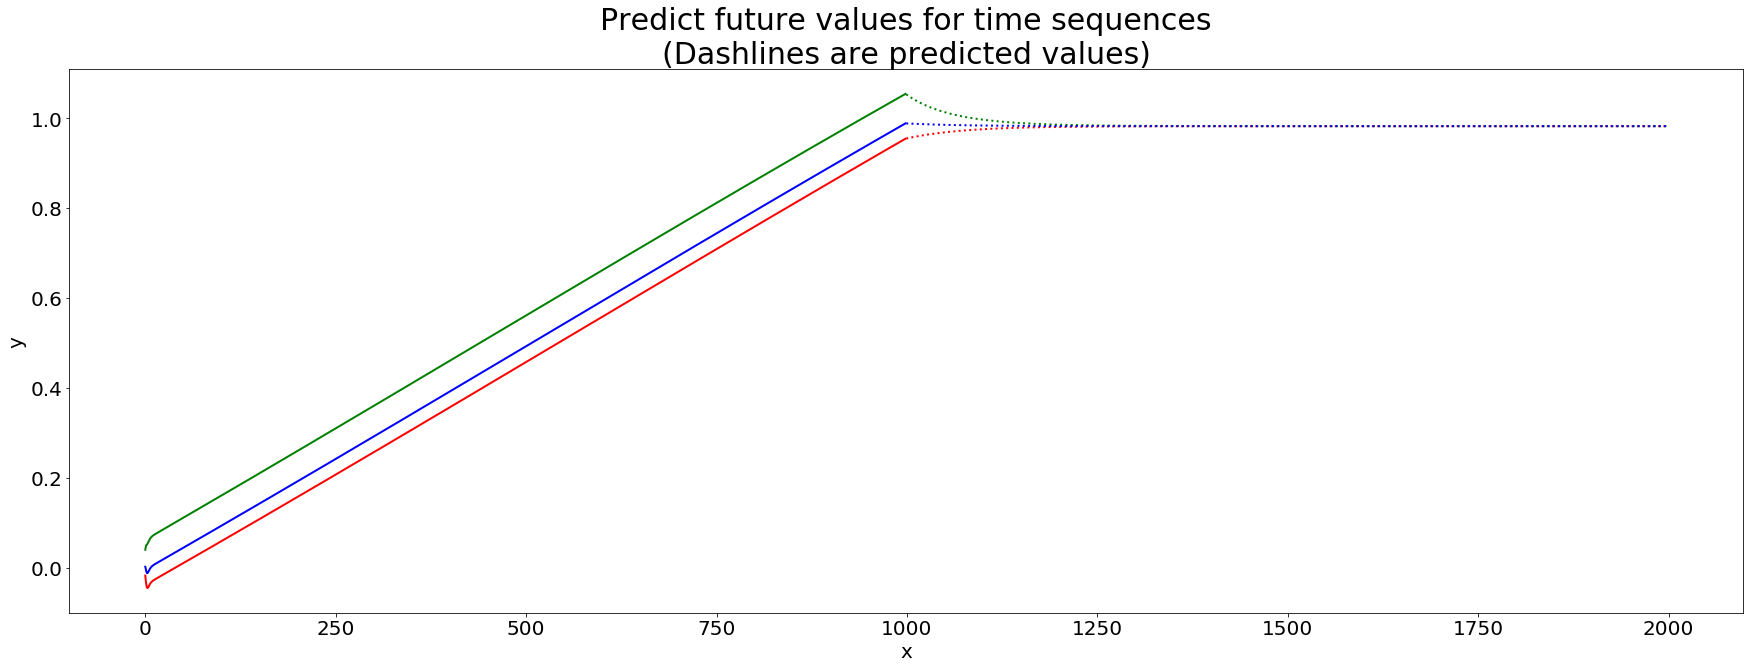

STEP: 10 loss: 1.9257181520515587e-06 test loss: 1.7209183624800062e-06


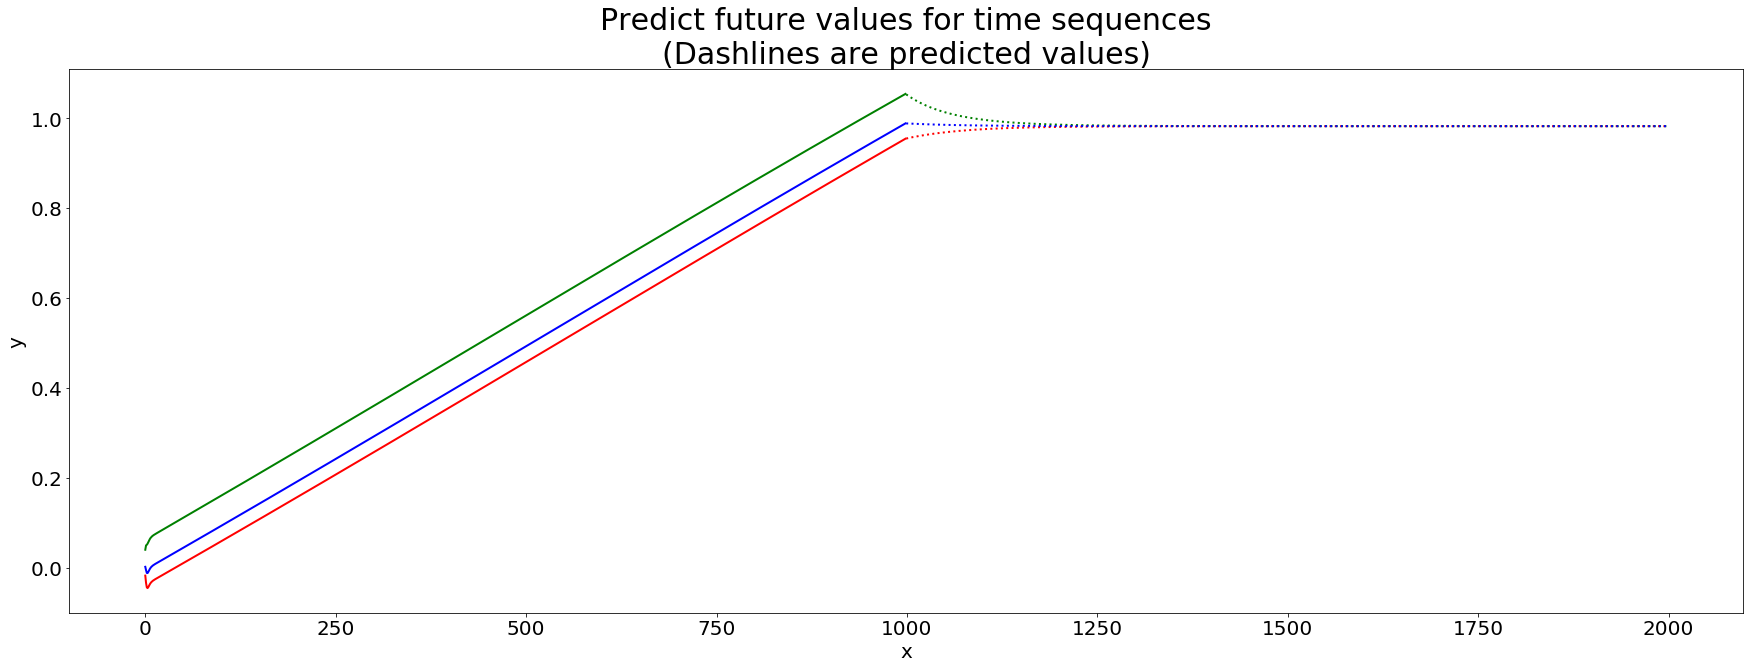

STEP: 11 loss: 1.92561878975539e-0606 test loss: 1.7208263898282894e-06


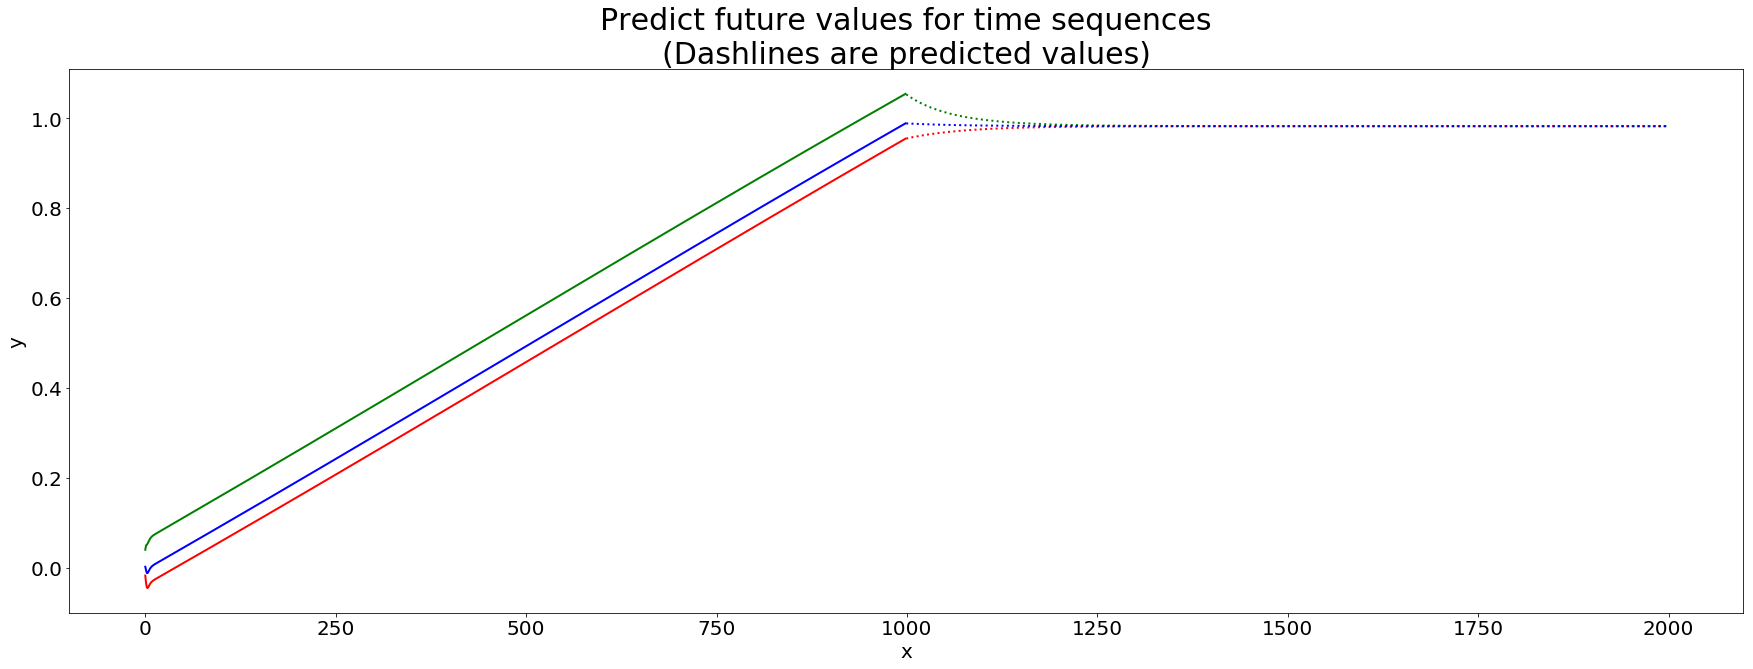

STEP: 12 loss: 1.925576725625433e-06 test loss: 1.7207893279191921e-06


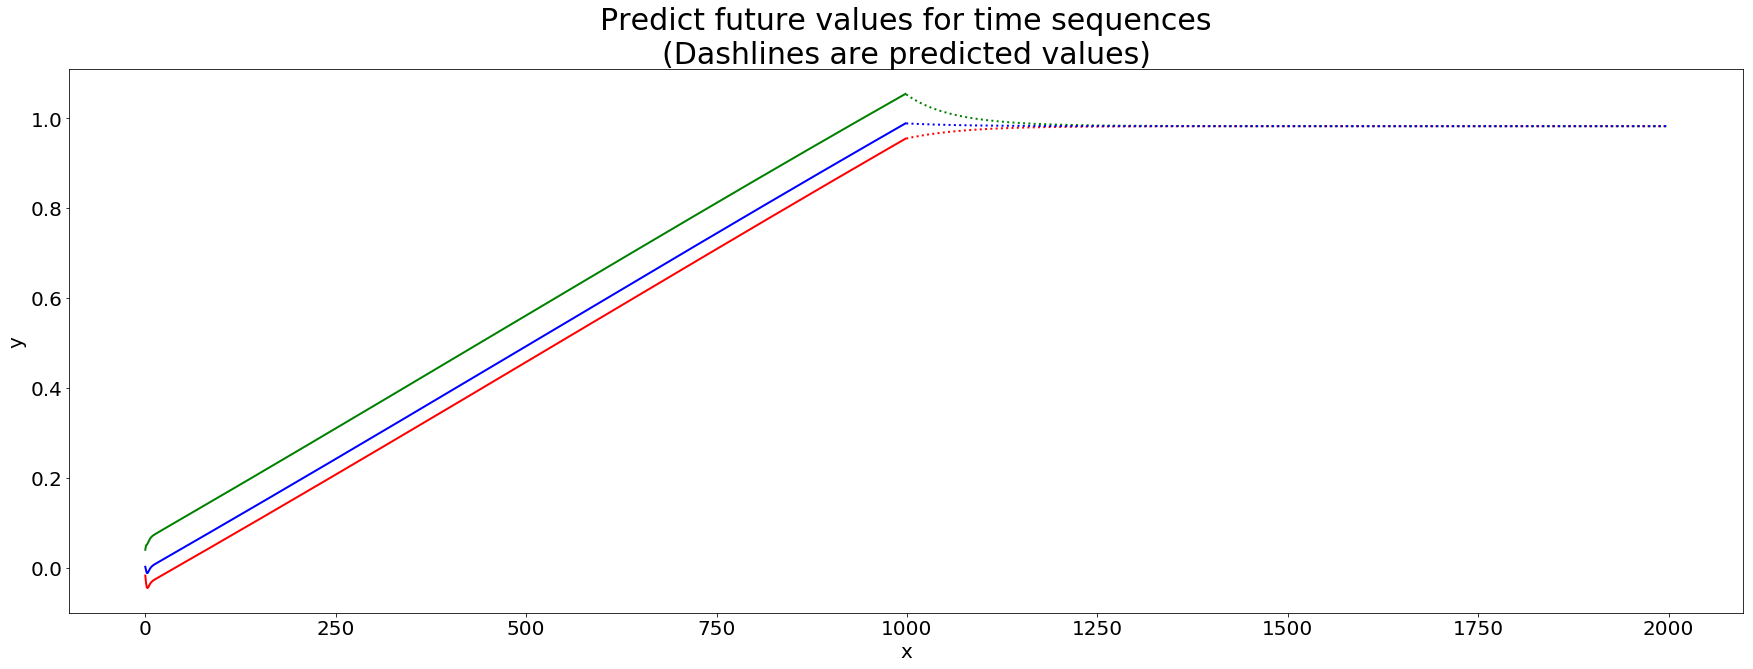

STEP: 13 loss: 1.925477135955589e-06 test loss: 1.7206940583491814e-06


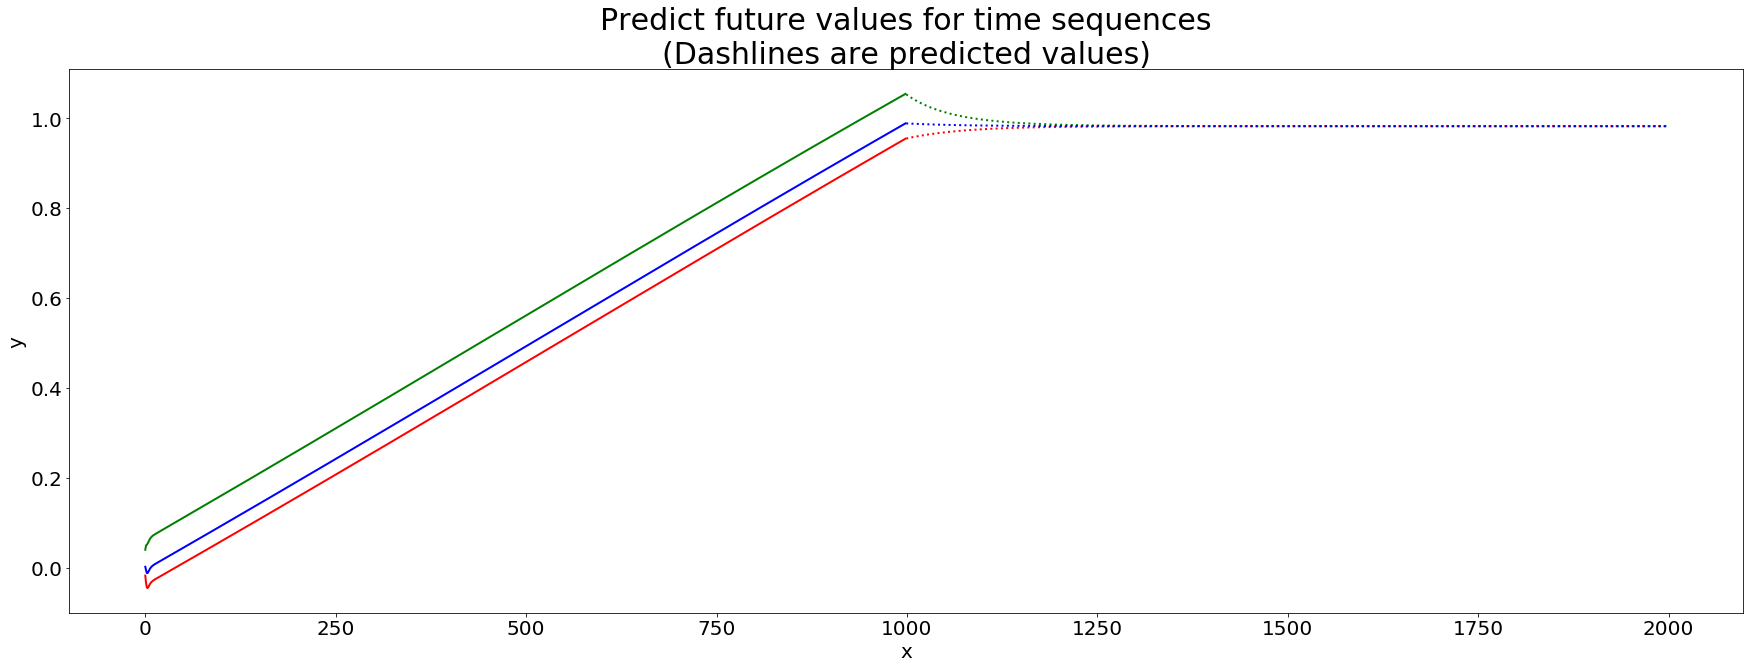

STEP: 14 loss: 1.92538027476985e-066 test loss: 1.720601972010627e-06


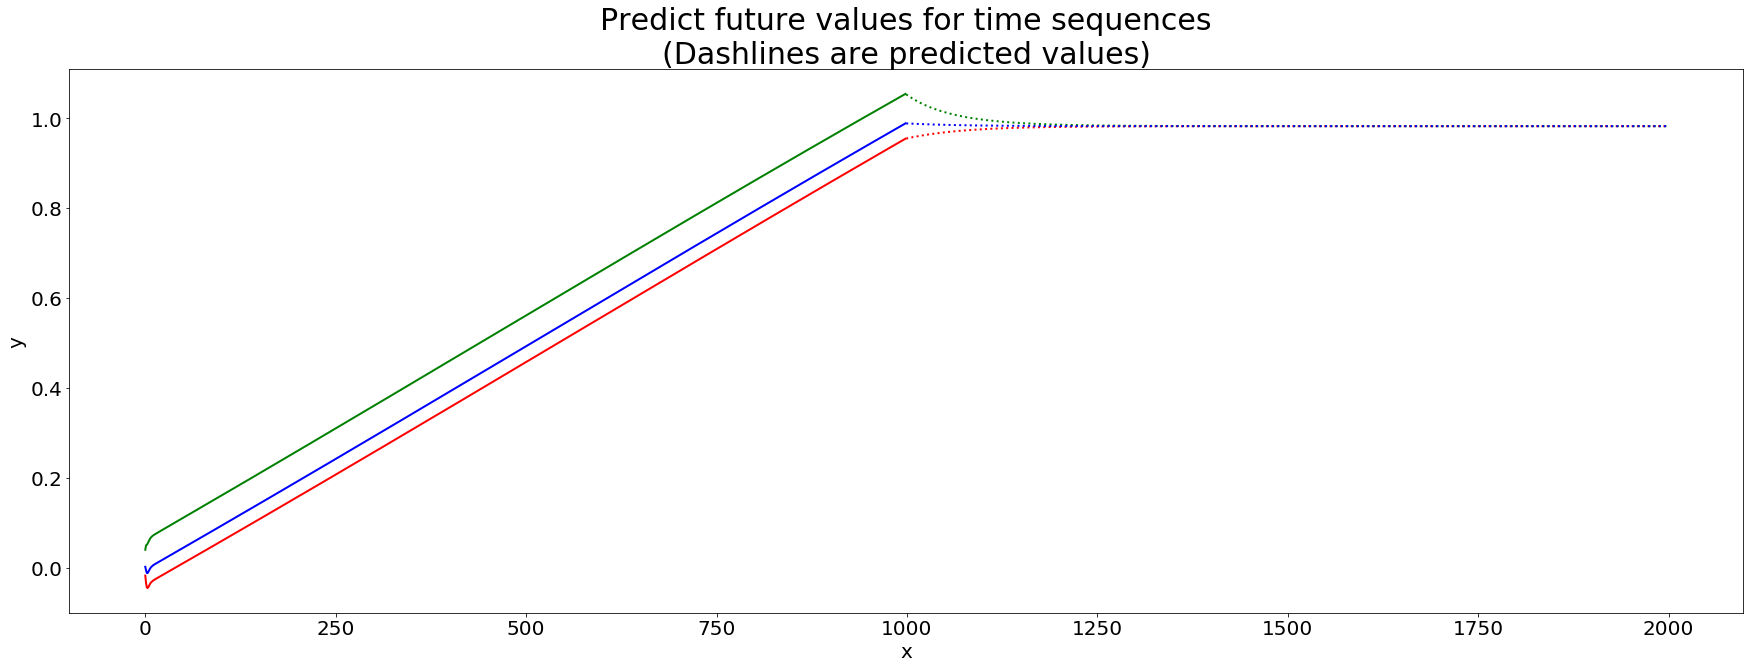

In [5]:
#begin to train
for i in range(15):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('\rSTEP:', i,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 1000
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    #plt.close()